E Card Game

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def random_policy(hand, opponent_hand=None):
    #from hand, play a random card
    return hand.pop(random.randint(0, len(hand) - 1))

In [4]:
slave_deck = ["C","C","C","C","S"]
king_deck = ["C","C","C","C","K"]


class Player:
    def __init__(self, name, hand,policy):
        self.name = name
        self.original_hand = hand.copy()  # Create a copy to avoid modifying the input
        self.hand = self.original_hand.copy()
        self.score = 0
        self.policy = policy
    def play_card(self, opponent_hand=None):
        #play a card based on the policy
        card_drawn = self.policy(self.hand, opponent_hand)
        #print(self.hand)
        return card_drawn
    def reset_hand(self):
        self.hand = self.original_hand.copy()
    def reset_score(self):
        self.score = 0

In [5]:
def outcome_game(player1_card, player2_card):
    # Determine winner of a single draw:
    # return 1 if player1 (first player passed) wins the draw,
    # return -1 if player2 wins the draw,
    # return 0 if tie.
    if player1_card == player2_card:
        return 0
    # Winning rules: Emperor (K) beats Citizen (C); Citizen (C) beats Slave (S); Slave (S) beats Emperor (K)
    if player1_card == "K" and player2_card == "C":
        return 1
    if player1_card == "C" and player2_card == "S":
        return 1
    if player1_card == "S" and player2_card == "K":
        return 1
    # Otherwise player2 wins the draw
    return -1
    
    

In [6]:
#single game class
class Round():
    def __init__(self, player1, player2):
        self.player1 = player1
        self.player2 = player2

    def play_round(self):
        while self.player1.hand and self.player2.hand:
            # policies receive (player, opponent) and must remove/return a card from player's deck
            card1 = self.player1.play_card(self.player2.hand.copy())
            card2 = self.player2.play_card(self.player1.hand.copy())
            #print(card1,card2)
            # determine draw outcome: 1 -> player1 wins draw, -1 -> player2 wins draw, 0 -> tie
            result = outcome_game(card1, card2)
            if result != 0:
                #print("Game done," + (" player 1 wins" if result > 0 else " player 2 wins"))
                # score is applied at match level (Game.play_one_match) so this single draw returns the result
                #reset hands
                self.player1.reset_hand()
                self.player2.reset_hand()
                #print(card1,card2,result)
                return card1, card2, result
        # if decks empty without winner, return tie, imposible situation
        return None, None, 0

In [7]:
#set player policy
# pass the policy function itself (do not call it)
king = Player("king", king_deck, random_policy)
slave = Player("slave", slave_deck, random_policy)
round = Round(king, slave)
round.play_round()

('C', 'S', 1)

In [8]:
n_rounds = 100000
king.reset_score()
slave.reset_score()
for i in range(n_rounds):
    winner = round.play_round()
    if winner[2] == 1:
        king.score += 1
    elif winner[2] == -1:
        slave.score += 5
print("Final Scores:")
print("King:", king.score/n_rounds)
print("Slave:", slave.score/n_rounds)

Final Scores:
King: 0.79961
Slave: 1.00195


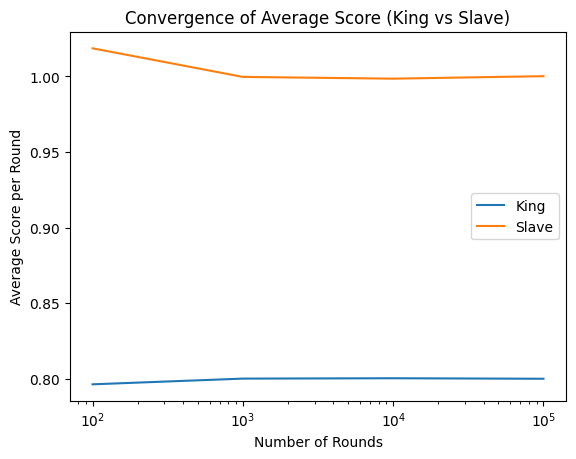

In [15]:
#plot a graph of the results
import matplotlib.pyplot as plt
replicates = 100
n_rounds_list = [100, 1000, 10000, 100000]
king_scores = []
slave_scores = []
for n_rounds in n_rounds_list:
    replicates_scores_king = []
    replicates_scores_slave = []
    for i in range(replicates):
        king.reset_score()
        slave.reset_score()
        for j in range(n_rounds):
            winner = round.play_round()
            if winner[2] == 1:
                king.score += 1
            elif winner[2] == -1:
                slave.score += 5
        replicates_scores_king.append(king.score)
        replicates_scores_slave.append(slave.score)
    # Calculate average score per round
    king_scores.append((sum(replicates_scores_king) / replicates) / n_rounds)
    slave_scores.append((sum(replicates_scores_slave) / replicates) / n_rounds)

plt.plot(n_rounds_list, king_scores, label="King")
plt.plot(n_rounds_list, slave_scores, label="Slave")
plt.xlabel("Number of Rounds")
plt.ylabel("Average Score per Round")
plt.title("Convergence of Average Score (King vs Slave)")
plt.legend()
plt.xscale('log') # Log scale helps visualize the orders of magnitude better
plt.show()

In [260]:
king = Player("king",king_deck,random_policy)
slave = Player("slave",slave_deck,random_policy)
round = Round(king,slave)
round.play_round()

('C', 'S', 1)

In [264]:
#new policy, king always plays C if available, else random
def king_policy(hand, opponent_hand=None):
    if "C" in hand:
        hand.remove("C")
        return "C"
    else:
        return "K"
king = Player("king",king_deck,king_policy)
slave = Player("slave",slave_deck,random_policy)
round = Round(king,slave)
results = {king:0, slave:0}
n_rounds = 100000
king.reset_score()
slave.reset_score()
for i in range(n_rounds):
    winner = round.play_round()
    if winner[2] == 1:
        king.score += 1
        results[king] += 1
    elif winner[2] == -1:
        slave.score += 5
        results[slave] += 1
print("Final Scores:")
print("Results:", {player.name: count for player, count in results.items()})
print("King:", king.score/n_rounds)
print("Slave:", slave.score/n_rounds)

Final Scores:
Results: {'king': 79864, 'slave': 20136}
King: 0.79864
Slave: 1.0068


In [266]:
def dla_policy(hand, opponent_hand):
    # Direct 1-step lookahead: choose card that maximizes expected immediate reward
    if not hand:
        return None
    
    # If opponent hand is not provided or empty, fallback to random
    if not opponent_hand:
        return hand.pop(random.randint(0, len(hand) - 1))

    best_idx = -1
    best_val = -float('inf')
    
    # Iterate over each card in our hand
    for i, card in enumerate(hand):
        exp = 0.0
        # Calculate expected value against all opponent cards
        for opp_card in opponent_hand:
            exp += outcome_game(card, opp_card)
        
        if len(opponent_hand) > 0:
            exp /= len(opponent_hand)
        
        if exp > best_val:
            best_val = exp
            best_idx = i
            
    # play the chosen card (remove from hand)
    return hand.pop(best_idx)

In [292]:
king = Player("king",king_deck,dla_policy)
slave = Player("slave",slave_deck,random_policy)
round = Round(king,slave)
round.play_round()

('K', 'C', 1)

In [269]:
#implement the dla policy for the king
king = Player("king", king_deck, dla_policy)
slave = Player("slave", slave_deck, random_policy)
round = Round(king, slave)

n_rounds = 100000
king.reset_score()
slave.reset_score()
results = {king: 0, slave: 0}

for i in range(n_rounds):
    winner = round.play_round()
    if winner[2] == 1:
        king.score += 1
        results[king] += 1
    elif winner[2] == -1:
        slave.score += 5
        results[slave] += 1

print("Final Scores (DLA vs Random):")
print("Results:", {player.name: count for player, count in results.items()})
print("King:", king.score/n_rounds)
print("Slave:", slave.score/n_rounds)

Final Scores (DLA vs Random):
Results: {'king': 80055, 'slave': 19945}
King: 0.80055
Slave: 0.99725


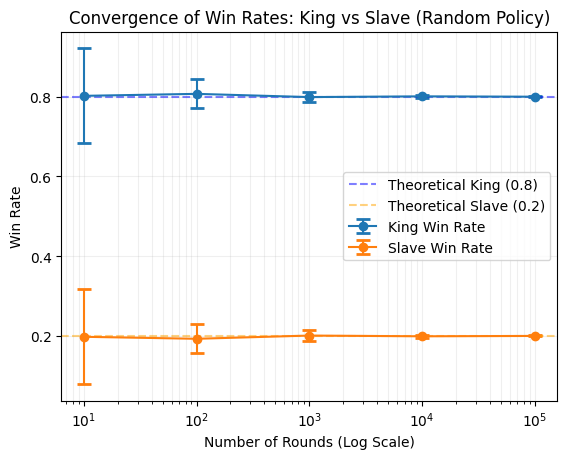


Summary Statistics:

n = 10 rounds:
  King:  Mean = 0.8020, SD = 0.1191
  Slave: Mean = 0.1980, SD = 0.1191

n = 100 rounds:
  King:  Mean = 0.8070, SD = 0.0363
  Slave: Mean = 0.1930, SD = 0.0363

n = 1,000 rounds:
  King:  Mean = 0.7989, SD = 0.0134
  Slave: Mean = 0.2011, SD = 0.0134

n = 10,000 rounds:
  King:  Mean = 0.8007, SD = 0.0041
  Slave: Mean = 0.1993, SD = 0.0041

n = 100,000 rounds:
  King:  Mean = 0.7998, SD = 0.0012
  Slave: Mean = 0.2002, SD = 0.0012


In [21]:
# Simulation to verify win probabilities (King ~0.8, Slave ~0.2)

# Setup simulation parameters
n_rounds_list = [10, 100, 1000, 10000, 100000]
n_replicates = 100

# Store results for each replicate
king_win_rates_all = []
slave_win_rates_all = []

# Initialize players with random policy
king_sim = Player("king", king_deck, random_policy)
slave_sim = Player("slave", slave_deck, random_policy)
round_sim = Round(king_sim, slave_sim)

for n in n_rounds_list:
    king_rates_replicates = []
    slave_rates_replicates = []
    
    for rep in range(n_replicates):
        king_wins = 0
        slave_wins = 0
        for _ in range(n):
            # play_round returns (card1, card2, result)
            # result 1 = King wins, -1 = Slave wins
            _, _, result = round_sim.play_round()
            
            if result == 1:
                king_wins += 1
            elif result == -1:
                slave_wins += 1
        
        king_rates_replicates.append(king_wins / n)
        slave_rates_replicates.append(slave_wins / n)
    
    king_win_rates_all.append(king_rates_replicates)
    slave_win_rates_all.append(slave_rates_replicates)

# Calculate means and standard deviations
king_mean = [np.mean(rates) for rates in king_win_rates_all]
king_std = [np.std(rates) for rates in king_win_rates_all]
slave_mean = [np.mean(rates) for rates in slave_win_rates_all]
slave_std = [np.std(rates) for rates in slave_win_rates_all]

# Plot: Win rates with error bars
plt.errorbar(n_rounds_list, king_mean, yerr=king_std, label="King Win Rate", 
             marker='o', capsize=5, capthick=2)
plt.errorbar(n_rounds_list, slave_mean, yerr=slave_std, label="Slave Win Rate", 
             marker='o', capsize=5, capthick=2)

# Theoretical lines
plt.axhline(y=0.8, color='blue', linestyle='--', alpha=0.5, label="Theoretical King (0.8)")
plt.axhline(y=0.2, color='orange', linestyle='--', alpha=0.5, label="Theoretical Slave (0.2)")

plt.xscale('log')
plt.xlabel("Number of Rounds (Log Scale)")
plt.ylabel("Win Rate")
plt.title("Convergence of Win Rates: King vs Slave (Random Policy)")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("=" * 60)
for i, n in enumerate(n_rounds_list):
    print(f"\nn = {n:,} rounds:")
    print(f"  King:  Mean = {king_mean[i]:.4f}, SD = {king_std[i]:.4f}")
    print(f"  Slave: Mean = {slave_mean[i]:.4f}, SD = {slave_std[i]:.4f}")